Hyperparameter Settings. Within each network topology, evaluate alternative settings for hyperparameters. Understand that the tuning of hyperparameter settings may be best accomplished by dividing the available data into training, validation, and test sets.

For each network under study, report on its structure and hyperparameter settings. Report on the time it takes to train each network and the performance of that network in the test set.

Visualizations. Employ visualizations to examine the performance of each network under study. Show training and validation set results (loss/cost and performance/accuracy) across epochs.

In [ ]:
!pip install plot-keras-history seaborn tensorflow-datasets

In [143]:
import datetime
from packaging import version
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import dill
import tensorflow as tf
import tensorflow_datasets as tfds
from timeit import default_timer as timer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Embedding, Bidirectional, LSTM, Dense, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from sklearn.model_selection import train_test_split
from IPython.core.interactiveshell import InteractiveShell
from plot_keras_history import plot_history
pd.options.mode.chained_assignment = None 

# Data Loading & Prep

In [6]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [7]:
dataset, info = tfds.load('AGNewsSubset', with_info=True, split='train+test', as_supervised=True)

Dataset ag_news_subset downloaded and prepared to C:\Users\bprescott\tensorflow_datasets\ag_news_subset\1.0.0. Subsequent calls will reuse this data.


In [8]:
df = tfds.as_dataframe(dataset, info)
df.head()

,description,label
0,b'AMD #39;s new dual-core Opteron chip is desi...,3
1,b'Reuters - Major League Baseball\\Monday anno...,1
2,b'President Bush #39;s quot;revenue-neutral q...,2
3,b'Britain will run out of leading scientists u...,3
4,"b'London, England (Sports Network) - England m...",1


In [9]:
categories = dict(enumerate(info.features["label"].names))
categories

{0: 'World', 1: 'Sports', 2: 'Business', 3: 'Sci/Tech'}

In [10]:
train_categories = [categories[label] for label in dataset.map(lambda text, label: label).as_numpy_iterator()]
Counter(train_categories)

Counter({'Sci/Tech': 31900,
         'Sports': 31900,
         'Business': 31900,
         'World': 31900})

In [8]:
encoder = TextVectorization(max_tokens=None)
encoder.adapt(dataset.map(lambda text, label: text))

# Experiments A: EDA



(a) Vocabulary Size: Tweak the vocabulary size, at least 3 levels, eg. vocab size of 1000, 2000, 3000. This way, we can get insights whether the performance metric is non linearly related to the vocab size.

(b) Editing the Vocabulary: Try unedited most frequent words, VERSUS edit the list by deleting the most frequent words such as article, ‘the’, ‘a’, etc.

(c) Output sequence length: Use the default VERSUS set it to a fixed number


Reviewing max vocabulary and word frequency

In [9]:
# Retreieving count of vocabulary words
vocab = np.array(encoder.get_vocabulary())
print(f"There are {len(vocab)} vocabulary words in the corpus.")

There are 95976 vocabulary words in the corpus.


In [10]:
doc_sizes = []
corpus = []
for example, _ in dataset.as_numpy_iterator():
  enc_example = encoder(example)
  doc_sizes.append(len(enc_example))
  corpus+=list(enc_example.numpy())

In [11]:
print(f"There are {len(corpus)} words in the corpus of {len(doc_sizes)} news articles.")
print(f"Each news article has between {min(doc_sizes)} and {max(doc_sizes)} tokens in it.")

There are 3909695 words in the corpus of 127600 news articles.
Each news article has between 3 and 173 tokens in it.


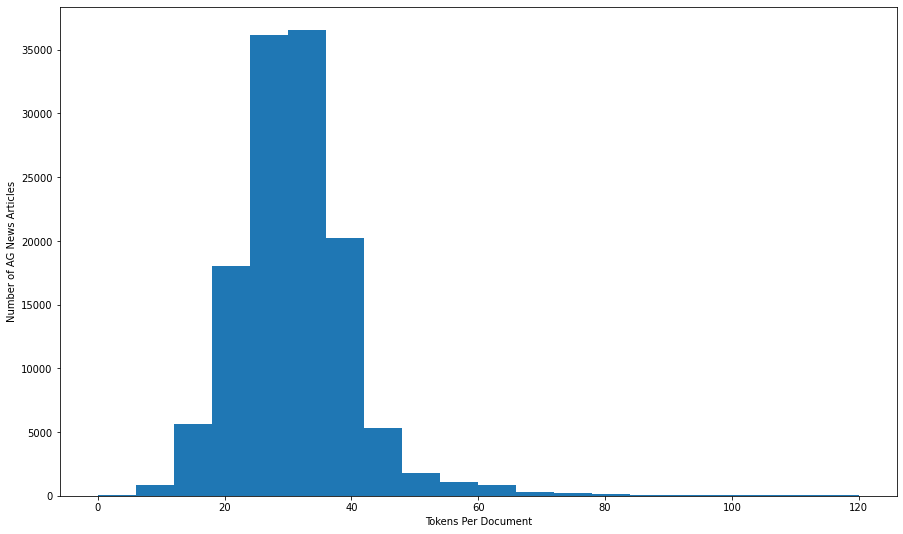

In [12]:
plt.figure(figsize=(15,9))
plt.hist(doc_sizes, bins=20,range = (0,120))
plt.xlabel("Tokens Per Document")
plt.ylabel("Number of AG News Articles");

Encoding documents using the 1000, 2000, and 3000 most common words

In [13]:
encoder_1000 = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=1000)
encoder_2000 = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=2000)
encoder_3000 = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=3000)

encoder_1000.adapt(dataset.map(lambda text, label: text))
encoder_2000.adapt(dataset.map(lambda text, label: text))
encoder_3000.adapt(dataset.map(lambda text, label: text))

vocab_1000 = np.array(encoder_1000.get_vocabulary())
vocab_2000 = np.array(encoder_2000.get_vocabulary())
vocab_3000 = np.array(encoder_3000.get_vocabulary())

In [29]:
doc1000_sizes = []
corpus1000 = []
count1000=0
useless = 0
# stop = 0
percents = []
for example, _ in dataset.as_numpy_iterator():
  # stop+=1
  # if stop > 5: break
  enc_example = encoder_1000(example)
  num_ones = tf.math.count_nonzero(enc_example==1).numpy()
  percent_ones = round(num_ones*100/len(enc_example))
  # print(f"{percent_ones}%")
  percents.append(percent_ones)

  s = set(list(enc_example.numpy()))
  if s == {1}: useless+=1

  doc1000_sizes.append(len(enc_example))
  corpus1000+=list(enc_example.numpy())

  count1000 += tf.math.count_nonzero(enc_example>1)

In [30]:
print(f"Each news article has between {min(doc1000_sizes)} and {max(doc1000_sizes)} tokens in it.")


Each news article has between 3 and 173 tokens in it.


## Train/Test/Validation Splits & Shuffling

In [11]:
X_train_full, X_test, y_train_full, y_test = train_test_split(df.description, df.label, test_size=.1, random_state=42, shuffle = True, stratify=df.label)

X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=.2, random_state=42, shuffle = True)

print(len(X_train), len(X_test), len(X_val))

91872 12760 22968


In [12]:
print(Counter(y_train).most_common())
print(Counter(y_test).most_common())
print(Counter(y_val).most_common())

[(2, 23033), (3, 22979), (0, 22977), (1, 22883)]
[(0, 3190), (1, 3190), (2, 3190), (3, 3190)]
[(1, 5827), (0, 5733), (3, 5731), (2, 5677)]


In [13]:
y_train_labels = [categories[label] for label in y_train]
Counter(y_train_labels).most_common()

[('Business', 23033), ('Sci/Tech', 22979), ('World', 22977), ('Sports', 22883)]

In [15]:
# create empty list to store network training times
train_times = []

## Creating Encodings

In [16]:
encoder_1000 = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=1000)
encoder_2000 = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=2000)
encoder_3000 = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=3000)

encoder_1000.adapt(list(X_train))
encoder_2000.adapt(list(X_train))
encoder_3000.adapt(list(X_train))

vocab_1000 = np.array(encoder_1000.get_vocabulary())
vocab_2000 = np.array(encoder_2000.get_vocabulary())
vocab_3000 = np.array(encoder_3000.get_vocabulary())

In [17]:
vocab_1000[:10]

array(['', '[UNK]', 'the', 'a', 'to', 'of', 'in', 'and', 'on', 'for'],
      dtype='<U14')

# Experiments B: RNN

Try several experiments by tweaking (i) architecture (ii) Bidirectional/unidirectional & other hyper parameters, including regularization.

## RNN #1 - Bidirectional Simple RNN w/ Vocab 1000

In [18]:
model1 = Sequential()

model1.add(encoder_1000)
model1.add(Embedding(input_dim=len(encoder_1000.get_vocabulary()), output_dim=64, mask_zero=True))
model1.add(Bidirectional(SimpleRNN(32)))
model1.add(Dense(20, activation='relu'))
model1.add(Dense(4, activation='softmax'))


In [19]:
model1.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [20]:
start = timer()

model1output = model1.fit(X_train,
                    y_train,
                    epochs = 100,
                    validation_data=(X_val,y_val),
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )

end = timer()

train_times.append(end-start)

Epoch 1/100
2871/2871 [==============================] - 323s 109ms/step - loss: 0.9982 - accuracy: 0.5436 - val_loss: 0.4953 - val_accuracy: 0.8209
Epoch 2/100
2871/2871 [==============================] - 309s 108ms/step - loss: 0.4770 - accuracy: 0.8289 - val_loss: 0.4638 - val_accuracy: 0.8325
Epoch 3/100
2871/2871 [==============================] - 304s 106ms/step - loss: 0.4480 - accuracy: 0.8394 - val_loss: 0.4546 - val_accuracy: 0.8333
Epoch 4/100
2871/2871 [==============================] - 302s 105ms/step - loss: 0.4245 - accuracy: 0.8481 - val_loss: 0.4381 - val_accuracy: 0.8402
Epoch 5/100
2871/2871 [==============================] - 298s 104ms/step - loss: 0.4099 - accuracy: 0.8545 - val_loss: 0.4236 - val_accuracy: 0.8464
Epoch 6/100
2871/2871 [==============================] - 298s 104ms/step - loss: 0.3909 - accuracy: 0.8619 - val_loss: 0.4154 - val_accuracy: 0.8477
Epoch 7/100
2871/2871 [==============================] - 292s 102ms/step - loss: 0.3718 - accuracy: 0.8692

In [81]:
m1test_loss, m1test_acc = model1.evaluate(X_test, y_test)

print('Test Loss: {}'.format(m1test_loss))
print('Test Accuracy: {}'.format(m1test_acc))

399/399 [==============================] - 6s 15ms/step - loss: 0.4160 - accuracy: 0.8500
Test Loss: 0.41601869463920593
Test Accuracy: 0.8500000238418579


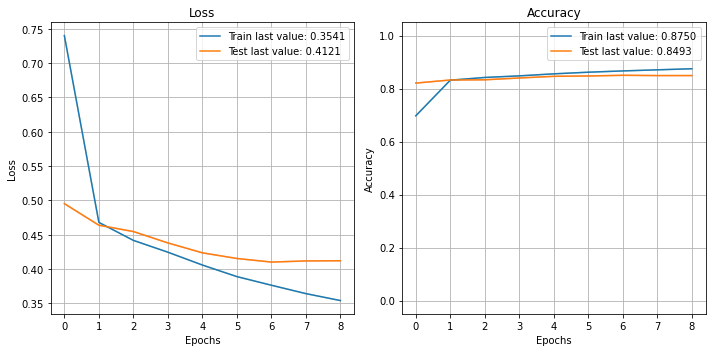

In [26]:
plot_history(model1output.history);

## RNN #2 - Bidirectional Simple RNN w/ Vocab 2000

In [27]:
model2 = Sequential()

model2.add(encoder_2000)
model2.add(Embedding(input_dim=len(encoder_2000.get_vocabulary()), output_dim=64, mask_zero=True))
model2.add(Bidirectional(SimpleRNN(32)))
model2.add(Dense(20, activation='relu'))
model2.add(Dense(4, activation='softmax'))

In [28]:
model2.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [29]:
start = timer()

model2output = model2.fit(X_train,
                    y_train,
                    epochs = 100,
                    validation_data=(X_val,y_val),
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )

end = timer()

train_times.append(end-start)

Epoch 1/100
2871/2871 [==============================] - 304s 105ms/step - loss: 0.9883 - accuracy: 0.5629 - val_loss: 0.4262 - val_accuracy: 0.8526
Epoch 2/100
2871/2871 [==============================] - 294s 102ms/step - loss: 0.3883 - accuracy: 0.8693 - val_loss: 0.3799 - val_accuracy: 0.8673
Epoch 3/100
2871/2871 [==============================] - 299s 104ms/step - loss: 0.3377 - accuracy: 0.8833 - val_loss: 0.3678 - val_accuracy: 0.8695
Epoch 4/100
2871/2871 [==============================] - 301s 105ms/step - loss: 0.3144 - accuracy: 0.8906 - val_loss: 0.3556 - val_accuracy: 0.8726
Epoch 5/100
2871/2871 [==============================] - 300s 105ms/step - loss: 0.3031 - accuracy: 0.8953 - val_loss: 0.3528 - val_accuracy: 0.8721
Epoch 6/100
2871/2871 [==============================] - 295s 103ms/step - loss: 0.2930 - accuracy: 0.8978 - val_loss: 0.3489 - val_accuracy: 0.8741
Epoch 7/100
2871/2871 [==============================] - 300s 104ms/step - loss: 0.2787 - accuracy: 0.9030

In [83]:
m2test_loss, m2test_acc = model2.evaluate(X_test, y_test)

print('Test Loss: {}'.format(m2test_loss))
print('Test Accuracy: {}'.format(m2test_acc))

399/399 [==============================] - 6s 15ms/step - loss: 0.3505 - accuracy: 0.8749
Test Loss: 0.3504621386528015
Test Accuracy: 0.8749216198921204


In [31]:
# plot_history(model2output);

## RNN #3 - Bidirectional Simple RNN w/ Vocab 3000

In [32]:
model3 = Sequential()

model3.add(encoder_3000)
model3.add(Embedding(input_dim=len(encoder_3000.get_vocabulary()), output_dim=64, mask_zero=True))
model3.add(Bidirectional(SimpleRNN(32)))
model3.add(Dense(20, activation='relu'))
model3.add(Dense(4, activation='softmax'))

In [33]:
model3.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [34]:
start = timer()

model3output = model3.fit(X_train,
                    y_train,
                    epochs = 100,
                    validation_data=(X_val,y_val),
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )

end = timer()

train_times.append(end-start)

Epoch 1/100
2871/2871 [==============================] - 306s 106ms/step - loss: 1.0145 - accuracy: 0.5362 - val_loss: 0.4221 - val_accuracy: 0.8537
Epoch 2/100
2871/2871 [==============================] - 295s 103ms/step - loss: 0.3699 - accuracy: 0.8775 - val_loss: 0.3498 - val_accuracy: 0.8794
Epoch 3/100
2871/2871 [==============================] - 300s 105ms/step - loss: 0.3061 - accuracy: 0.8964 - val_loss: 0.3415 - val_accuracy: 0.8821
Epoch 4/100
2871/2871 [==============================] - 301s 105ms/step - loss: 0.2894 - accuracy: 0.9029 - val_loss: 0.3332 - val_accuracy: 0.8851
Epoch 5/100
2871/2871 [==============================] - 302s 105ms/step - loss: 0.2737 - accuracy: 0.9068 - val_loss: 0.3301 - val_accuracy: 0.8870
Epoch 6/100
2871/2871 [==============================] - 296s 103ms/step - loss: 0.2601 - accuracy: 0.9124 - val_loss: 0.3480 - val_accuracy: 0.8804
Epoch 7/100
2871/2871 [==============================] - 300s 105ms/step - loss: 0.2483 - accuracy: 0.9154

In [84]:
m3test_loss, m3test_acc = model3.evaluate(X_test, y_test)

print('Test Loss: {}'.format(m3test_loss))
print('Test Accuracy: {}'.format(m3test_acc))

399/399 [==============================] - 6s 15ms/step - loss: 0.3404 - accuracy: 0.8816
Test Loss: 0.34042319655418396
Test Accuracy: 0.8815830945968628


In [36]:
# plot_history(model3output);

In [37]:
# plt.scatter('Model1',max(history.history['accuracy']))
# plt.scatter('Model2',max(model2output.history['accuracy']))
# plt.scatter('Model3',max(model3output.history['accuracy']))
# # plt.plot('Model2',max(model2output.history['accuracy']))
# # plt.plot('Model3',max(model3output.history['accuracy']))

# Experiments C: LSTM

Try several experiments by tweaking (i) architecture (ii) Bidirectional/unidirectional & other hyper parameters, including regularization.

## LSTM #1 - One Bidirectional LSTM Layer 

In [38]:
model4 = Sequential()

model4.add(encoder_1000)
model4.add(Embedding(input_dim=len(encoder_1000.get_vocabulary()), output_dim=64, mask_zero=True))
model4.add(Bidirectional(LSTM(64)))
model4.add(Dense(20, activation='relu'))
model4.add(Dense(4, activation='softmax'))

In [39]:
model4.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [40]:
start = timer()

model4output = model4.fit(X_train,
                    y_train,
                    epochs = 100,
                    validation_data=(X_val,y_val),
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )

end = timer()

train_times.append(end-start)

Epoch 1/100
2871/2871 [==============================] - 136s 36ms/step - loss: 1.0421 - accuracy: 0.5428 - val_loss: 0.5254 - val_accuracy: 0.8153
Epoch 2/100
2871/2871 [==============================] - 98s 34ms/step - loss: 0.5030 - accuracy: 0.8200 - val_loss: 0.4707 - val_accuracy: 0.8305
Epoch 3/100
2871/2871 [==============================] - 98s 34ms/step - loss: 0.4509 - accuracy: 0.8387 - val_loss: 0.4462 - val_accuracy: 0.8375
Epoch 4/100
2871/2871 [==============================] - 98s 34ms/step - loss: 0.4238 - accuracy: 0.8475 - val_loss: 0.4320 - val_accuracy: 0.8420
Epoch 5/100
2871/2871 [==============================] - 98s 34ms/step - loss: 0.4058 - accuracy: 0.8533 - val_loss: 0.4153 - val_accuracy: 0.8464
Epoch 6/100
2871/2871 [==============================] - 98s 34ms/step - loss: 0.3902 - accuracy: 0.8580 - val_loss: 0.4123 - val_accuracy: 0.8477
Epoch 7/100
2871/2871 [==============================] - 97s 34ms/step - loss: 0.3835 - accuracy: 0.8632 - val_loss: 

In [85]:
m4test_loss, m4test_acc = model4.evaluate(X_test, y_test)

print('Test Loss: {}'.format(m4test_loss))
print('Test Accuracy: {}'.format(m4test_acc))

399/399 [==============================] - 4s 11ms/step - loss: 0.3903 - accuracy: 0.8610
Test Loss: 0.39029231667518616
Test Accuracy: 0.8609718084335327


## LSTM #2 - Two Bidirectional LSTM Layers 

In [41]:
model5 = Sequential()

model5.add(encoder_1000)
model5.add(Embedding(input_dim=len(encoder_1000.get_vocabulary()), output_dim=64, mask_zero=True))
model5.add(Bidirectional(LSTM(64, return_sequences=True)))
model5.add(Bidirectional(LSTM(32)))
model5.add(Dense(20, activation='relu'))
model5.add(Dense(4, activation='softmax'))

In [42]:
model5.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [43]:
start = timer()

model5output = model5.fit(X_train,
                    y_train,
                    epochs = 100,
                    validation_data=(X_val,y_val),
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )

end = timer()

train_times.append(end-start)

Epoch 1/100
2871/2871 [==============================] - 202s 64ms/step - loss: 0.9742 - accuracy: 0.5658 - val_loss: 0.4881 - val_accuracy: 0.8269
Epoch 2/100
2871/2871 [==============================] - 174s 60ms/step - loss: 0.4565 - accuracy: 0.8398 - val_loss: 0.4543 - val_accuracy: 0.8327
Epoch 3/100
2871/2871 [==============================] - 173s 60ms/step - loss: 0.4060 - accuracy: 0.8580 - val_loss: 0.4079 - val_accuracy: 0.8520
Epoch 4/100
2871/2871 [==============================] - 172s 60ms/step - loss: 0.3886 - accuracy: 0.8604 - val_loss: 0.4067 - val_accuracy: 0.8514
Epoch 5/100
2871/2871 [==============================] - 173s 60ms/step - loss: 0.3800 - accuracy: 0.8641 - val_loss: 0.3995 - val_accuracy: 0.8544
Epoch 6/100
2871/2871 [==============================] - 174s 61ms/step - loss: 0.3694 - accuracy: 0.8682 - val_loss: 0.3969 - val_accuracy: 0.8538
Epoch 7/100
2871/2871 [==============================] - 173s 60ms/step - loss: 0.3695 - accuracy: 0.8670 - val_

In [86]:
m5test_loss, m5test_acc = model5.evaluate(X_test, y_test)

print('Test Loss: {}'.format(m5test_loss))
print('Test Accuracy: {}'.format(m5test_acc))

399/399 [==============================] - 9s 21ms/step - loss: 0.4001 - accuracy: 0.8563
Test Loss: 0.4000587463378906
Test Accuracy: 0.8563479781150818


## LSTM #3 - Three Bidirectional LSTM Layers

In [44]:
model6 = Sequential()

model6.add(encoder_1000)
model6.add(Embedding(input_dim=len(encoder_1000.get_vocabulary()), output_dim=64, mask_zero=True))
model6.add(Bidirectional(LSTM(64, return_sequences=True)))
model6.add(Bidirectional(LSTM(32, return_sequences=True)))
model6.add(Bidirectional(LSTM(16)))
model6.add(Dense(20, activation='relu'))
model6.add(Dense(4, activation='softmax'))

In [45]:
model6.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [46]:
start = timer()

model6output = model6.fit(X_train,
                    y_train,
                    epochs = 100,
                    validation_data=(X_val,y_val),
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )

end = timer()

train_times.append(end-start)

Epoch 1/100
2871/2871 [==============================] - 287s 90ms/step - loss: 0.9621 - accuracy: 0.5551 - val_loss: 0.4999 - val_accuracy: 0.8172
Epoch 2/100
2871/2871 [==============================] - 247s 86ms/step - loss: 0.4580 - accuracy: 0.8363 - val_loss: 0.4331 - val_accuracy: 0.8431
Epoch 3/100
2871/2871 [==============================] - 247s 86ms/step - loss: 0.4187 - accuracy: 0.8514 - val_loss: 0.4173 - val_accuracy: 0.8484
Epoch 4/100
2871/2871 [==============================] - 247s 86ms/step - loss: 0.3935 - accuracy: 0.8613 - val_loss: 0.4087 - val_accuracy: 0.8517
Epoch 5/100
2871/2871 [==============================] - 246s 86ms/step - loss: 0.3811 - accuracy: 0.8647 - val_loss: 0.3971 - val_accuracy: 0.8545
Epoch 6/100
2871/2871 [==============================] - 247s 86ms/step - loss: 0.3743 - accuracy: 0.8652 - val_loss: 0.3972 - val_accuracy: 0.8544
Epoch 7/100
2871/2871 [==============================] - 247s 86ms/step - loss: 0.3688 - accuracy: 0.8682 - val_

In [88]:
m6test_loss, m6test_acc = model6.evaluate(X_test, y_test)

print('Test Loss: {}'.format(m6test_loss))
print('Test Accuracy: {}'.format(m6test_acc))

399/399 [==============================] - 12s 30ms/step - loss: 0.4020 - accuracy: 0.8578
Test Loss: 0.4019920527935028
Test Accuracy: 0.8578369617462158


# Experiments D: 1D CNN



## 1D CNN #1 - One CNN and Pooling Layer

In [92]:
model7 = Sequential()

model7.add(encoder_1000)
model7.add(Embedding(input_dim=len(encoder_1000.get_vocabulary()), output_dim=64, mask_zero=True))
model7.add(Conv1D(64, 3, activation='relu'))
model7.add(GlobalMaxPooling1D())
model7.add(Dense(20, activation='relu'))
model7.add(Dense(4, activation='softmax'))

In [93]:
model7.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [94]:
start = timer()

model7output = model7.fit(X_train,
                    y_train,
                    epochs = 10,
                    validation_data=(X_val,y_val),
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )

end = timer()

# train_times.append(end-start)

Epoch 1/10
2871/2871 [==============================] - 16s 5ms/step - loss: 1.1748 - accuracy: 0.4590 - val_loss: 0.5151 - val_accuracy: 0.8220
Epoch 2/10
2871/2871 [==============================] - 15s 5ms/step - loss: 0.4859 - accuracy: 0.8346 - val_loss: 0.4497 - val_accuracy: 0.8402
Epoch 3/10
2871/2871 [==============================] - 15s 5ms/step - loss: 0.4323 - accuracy: 0.8496 - val_loss: 0.4279 - val_accuracy: 0.8450
Epoch 4/10
2871/2871 [==============================] - 15s 5ms/step - loss: 0.4015 - accuracy: 0.8581 - val_loss: 0.4169 - val_accuracy: 0.8506
Epoch 5/10
2871/2871 [==============================] - 15s 5ms/step - loss: 0.3782 - accuracy: 0.8665 - val_loss: 0.4079 - val_accuracy: 0.8502
Epoch 6/10
2871/2871 [==============================] - 15s 5ms/step - loss: 0.3700 - accuracy: 0.8695 - val_loss: 0.4021 - val_accuracy: 0.8509
Epoch 7/10
2871/2871 [==============================] - 15s 5ms/step - loss: 0.3619 - accuracy: 0.8711 - val_loss: 0.3995 - val_ac

In [95]:
m7test_loss, m7test_acc = model7.evaluate(X_test, y_test)

print('Test Loss: {}'.format(m7test_loss))
print('Test Accuracy: {}'.format(m7test_acc))

399/399 [==============================] - 1s 3ms/step - loss: 0.3997 - accuracy: 0.8579
Test Loss: 0.3996756970882416
Test Accuracy: 0.8579153418540955


## 1D CNN #2 - Two CNN and Pooling Layers

In [73]:
model8 = Sequential()

model8.add(encoder_1000)
model8.add(Embedding(input_dim=len(encoder_1000.get_vocabulary()), output_dim=64, mask_zero=True))
model8.add(Conv1D(64, 3, activation='relu'))
model8.add(MaxPooling1D(2))
model8.add(Conv1D(64, 3, activation='relu'))
model8.add(GlobalMaxPooling1D())
model8.add(Dense(20, activation='relu'))
model8.add(Dense(4, activation='softmax'))

In [74]:
model8.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [75]:
start = timer()

model8output = model8.fit(X_train,
                    y_train,
                    epochs = 10,
                    validation_data=(X_val,y_val),
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )

end = timer()

train_times.append(end-start)

Epoch 1/10
2871/2871 [==============================] - 18s 6ms/step - loss: 1.1116 - accuracy: 0.4790 - val_loss: 0.5014 - val_accuracy: 0.8251
Epoch 2/10
2871/2871 [==============================] - 17s 6ms/step - loss: 0.4763 - accuracy: 0.8358 - val_loss: 0.4526 - val_accuracy: 0.8387
Epoch 3/10
2871/2871 [==============================] - 17s 6ms/step - loss: 0.4322 - accuracy: 0.8478 - val_loss: 0.4327 - val_accuracy: 0.8440
Epoch 4/10
2871/2871 [==============================] - 17s 6ms/step - loss: 0.4085 - accuracy: 0.8560 - val_loss: 0.4213 - val_accuracy: 0.8461
Epoch 5/10
2871/2871 [==============================] - 17s 6ms/step - loss: 0.3904 - accuracy: 0.8625 - val_loss: 0.4184 - val_accuracy: 0.8491
Epoch 6/10
2871/2871 [==============================] - 17s 6ms/step - loss: 0.3766 - accuracy: 0.8676 - val_loss: 0.4115 - val_accuracy: 0.8508
Epoch 7/10
2871/2871 [==============================] - 17s 6ms/step - loss: 0.3700 - accuracy: 0.8704 - val_loss: 0.4101 - val_ac

In [96]:
m8test_loss, m8test_acc = model8.evaluate(X_test, y_test)

print('Test Loss: {}'.format(m8test_loss))
print('Test Accuracy: {}'.format(m8test_acc))

399/399 [==============================] - 1s 3ms/step - loss: 0.4116 - accuracy: 0.8518
Test Loss: 0.41160181164741516
Test Accuracy: 0.8518025279045105


## 1D CNN #3 - Three CNN and Pooling Layers

In [77]:
model9 = Sequential()

model9.add(encoder_1000)
model9.add(Embedding(input_dim=len(encoder_1000.get_vocabulary()), output_dim=64, mask_zero=True))
model9.add(Conv1D(64, 3, activation='relu'))
model9.add(MaxPooling1D(2))
model9.add(Conv1D(64, 3, activation='relu'))
model9.add(MaxPooling1D(2))
model9.add(Conv1D(32, 3, activation='relu'))
model9.add(GlobalMaxPooling1D())
model9.add(Dense(20, activation='relu'))
model9.add(Dense(4, activation='softmax'))

In [78]:
model9.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [79]:
start = timer()

model9output = model9.fit(X_train,
                    y_train,
                    epochs = 10,
                    validation_data=(X_val,y_val),
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )

end = timer()

train_times.append(end-start)

Epoch 1/10
2871/2871 [==============================] - 21s 7ms/step - loss: 1.1340 - accuracy: 0.4651 - val_loss: 0.5148 - val_accuracy: 0.8153
Epoch 2/10
2871/2871 [==============================] - 19s 7ms/step - loss: 0.4970 - accuracy: 0.8238 - val_loss: 0.4645 - val_accuracy: 0.8339
Epoch 3/10
2871/2871 [==============================] - 19s 7ms/step - loss: 0.4444 - accuracy: 0.8433 - val_loss: 0.4428 - val_accuracy: 0.8417
Epoch 4/10
2871/2871 [==============================] - 19s 7ms/step - loss: 0.4155 - accuracy: 0.8529 - val_loss: 0.4319 - val_accuracy: 0.8436
Epoch 5/10
2871/2871 [==============================] - 19s 7ms/step - loss: 0.4005 - accuracy: 0.8574 - val_loss: 0.4216 - val_accuracy: 0.8465
Epoch 6/10
2871/2871 [==============================] - 19s 7ms/step - loss: 0.3897 - accuracy: 0.8625 - val_loss: 0.4200 - val_accuracy: 0.8473
Epoch 7/10
2871/2871 [==============================] - 19s 7ms/step - loss: 0.3776 - accuracy: 0.8642 - val_loss: 0.4181 - val_ac

In [97]:
m9test_loss, m9test_acc = model9.evaluate(X_test, y_test)

print('Test Loss: {}'.format(m9test_loss))
print('Test Accuracy: {}'.format(m9test_acc))

399/399 [==============================] - 1s 3ms/step - loss: 0.4237 - accuracy: 0.8507
Test Loss: 0.42365461587905884
Test Accuracy: 0.8507053256034851


# Results

Create a table with the accuracy and loss for train/test/validation & process time for all the models

In [164]:
modelhistories = [model1output.history,model2output.history,model3output.history,model4output.history,
                  model5output.history,model6output.history,model7output.history,model8output.history,
                  model9output.history,]

modeldescriptions = ['Bidirectional Simple RNN (vocab1000)',
                     'Bidirectional Simple RNN (vocab2000)',
                     'Bidirectional Simple RNN (vocab3000)',
                     'One Bidirectional LSTM Layer',
                     'Two Bidirectional LSTM Layers',
                     'Three Bidirectional LSTM Layers',
                     'One CNN and Pooling Layer',
                     'Two CNN and Pooling Layers',
                     'Three CNN and Pooling Layers']

modeltestaccuracies = [m1test_acc, m2test_acc, m3test_acc, m4test_acc, m5test_acc,
                      m6test_acc, m7test_acc, m8test_acc, m9test_acc]

modeltestlosses = [m1test_loss, m2test_loss, m3test_loss, m4test_loss, m5test_loss,
                   m6test_loss, m7test_loss, m8test_loss, m9test_loss]

In [165]:
model_results = pd.DataFrame()
model_results['model_description'] = modeldescriptions
model_results['vocab_length'] = 1000
model_results['vocab_length'][1] = 2000
model_results['vocab_length'][2] = 3000
model_results['training_time_seconds'] = train_times
model_results['training_time_minutes'] = model_results['training_time_seconds'].div(60)
model_results['train_accuracy'] = [max(m['accuracy']) for m in modelhistories]
model_results['train_loss'] = [min(m['loss']) for m in modelhistories]
model_results['validation_accuracy'] = [max(m['val_accuracy']) for m in modelhistories]
model_results['validation_loss'] = [min(m['val_loss']) for m in modelhistories]
model_results['test_accuracy'] = [m for m in modeltestaccuracies]
model_results['test_loss'] = [m for m in modeltestlosses]

model_results

,model_description,vocab_length,training_time_seconds,training_time_minutes,train_accuracy,train_loss,validation_accuracy,validation_loss,test_accuracy,test_loss
0,Bidirectional Simple RNN (vocab1000),1000,2723.880524,45.398009,0.875022,0.354111,0.850313,0.410151,0.850000,0.416019
1,Bidirectional Simple RNN (vocab2000),2000,2395.023041,39.917051,0.905978,0.270160,0.874086,0.348890,0.874922,0.350462
2,Bidirectional Simple RNN (vocab3000),3000,2101.480925,35.024682,0.912781,0.255888,0.886973,0.329014,0.881583,0.340423
3,One Bidirectional LSTM Layer,1000,1407.821836,23.463697,0.872812,0.351704,0.856931,0.387163,0.860972,0.390292
4,Two Bidirectional LSTM Layers,1000,1762.389815,29.373164,0.870450,0.356899,0.855582,0.391117,0.856348,0.400059
5,Three Bidirectional LSTM Layers,1000,1768.257346,29.470956,0.867098,0.369944,0.854537,0.396339,0.857837,0.401992
6,One CNN and Pooling Layer,1000,163.607247,2.726787,0.880802,0.336002,0.855712,0.393639,0.857915,0.399676
7,Two CNN and Pooling Layers,1000,171.829821,2.863830,0.875359,0.352194,0.853710,0.403282,0.851803,0.411602
8,Three CNN and Pooling Layers,1000,190.226183,3.170436,0.870091,0.363856,0.851010,0.412019,0.850705,0.423655


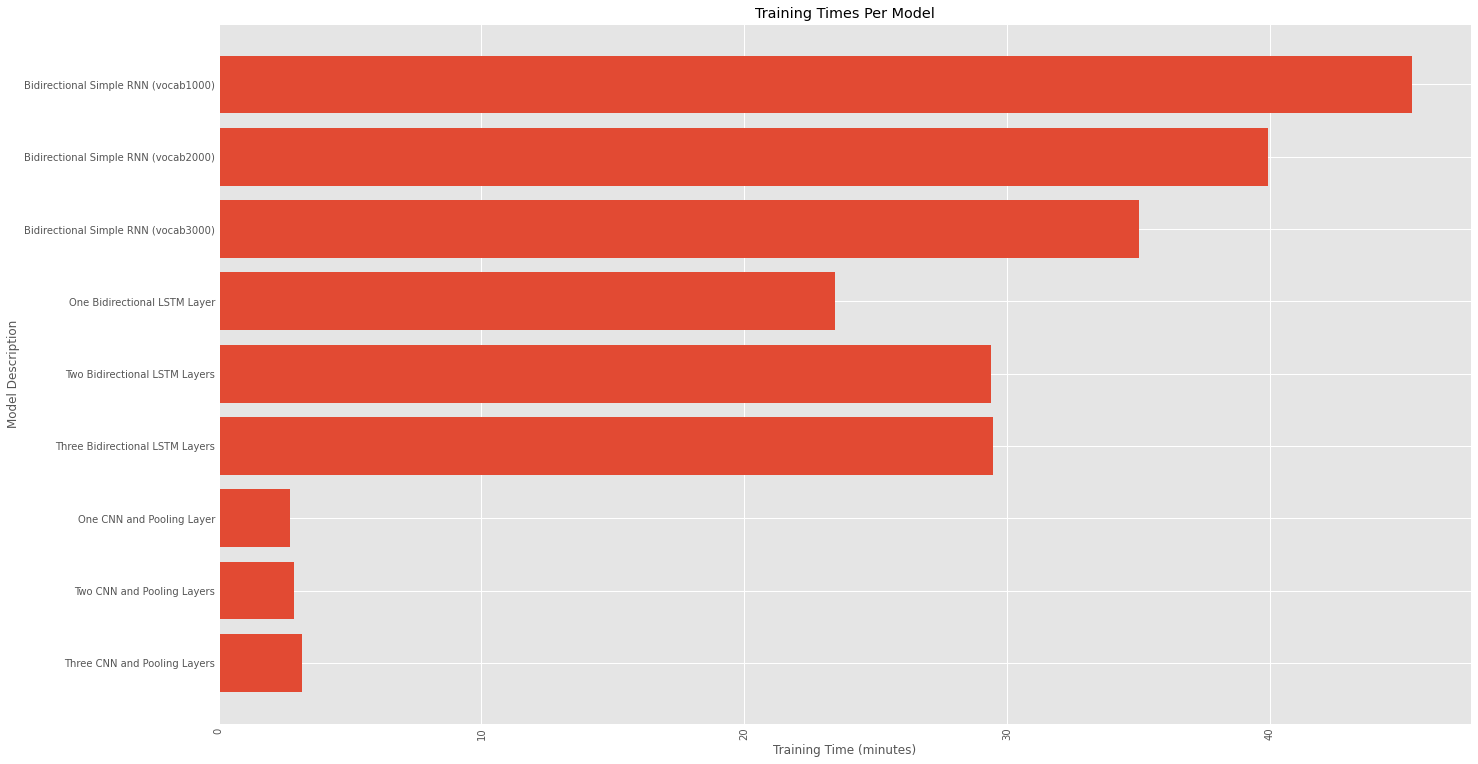

In [180]:
plt.rcParams.update({'font.size': 24})
plt.figure(figsize=(20,12))
plt.style.use('ggplot')
plt.barh(model_results['model_description'], model_results['training_time_minutes'])
plt.ylabel('Model Description')
plt.xlabel('Training Time (minutes)')
plt.title('Training Times Per Model')
plt.gca().invert_yaxis()
plt.xticks(rotation = 90)
plt.show();

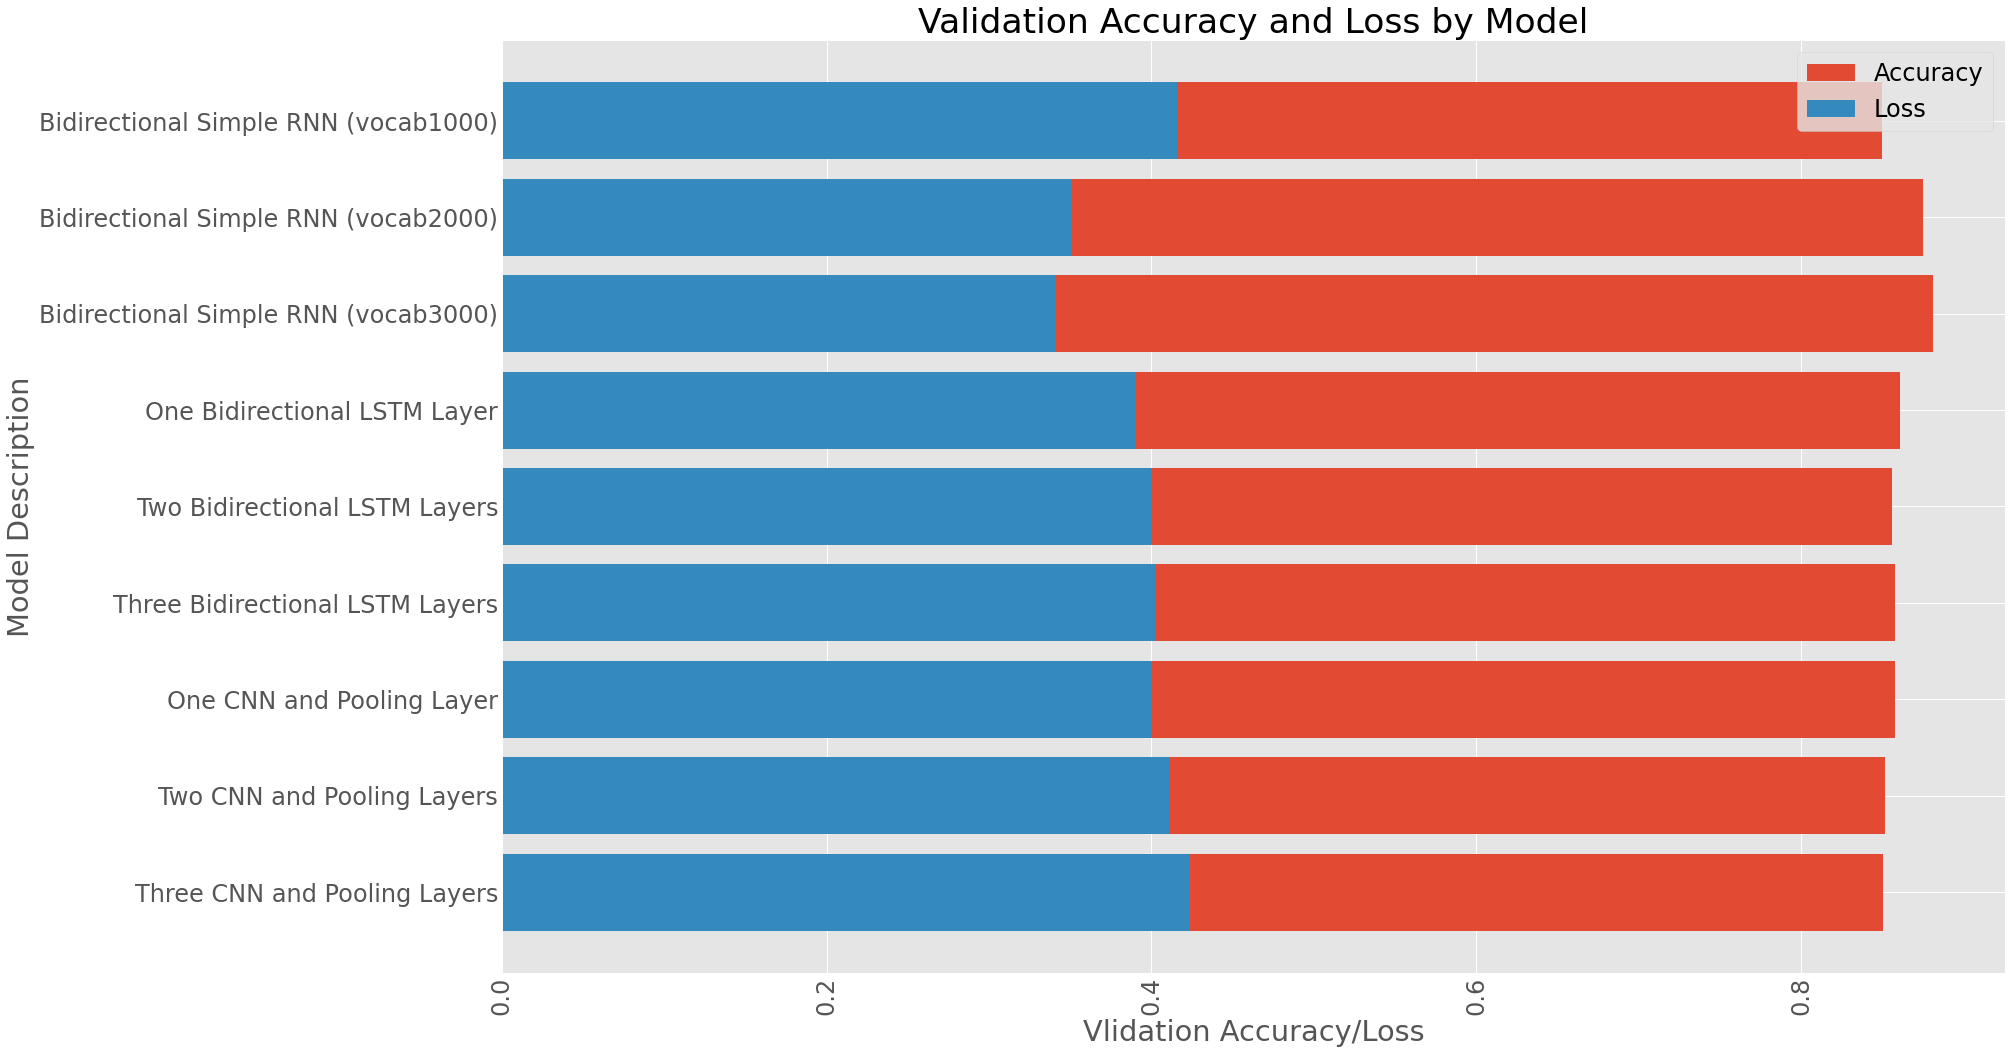

In [208]:

plt.figure(figsize=(24,16))
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 24})
plt.barh(model_results['model_description'], model_results['test_accuracy'], label='Accuracy')
plt.barh(model_results['model_description'], model_results['test_loss'], label='Loss')
plt.ylabel('Model Description')
plt.xlabel('Vlidation Accuracy/Loss')
plt.title('Validation Accuracy and Loss by Model')
plt.gca().invert_yaxis()
plt.xticks(rotation = 90)
plt.legend()
plt.show();

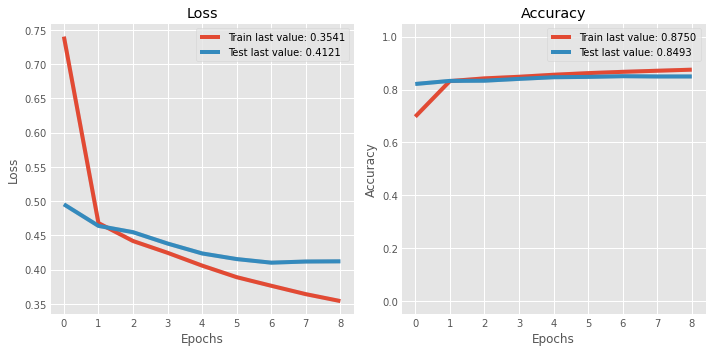

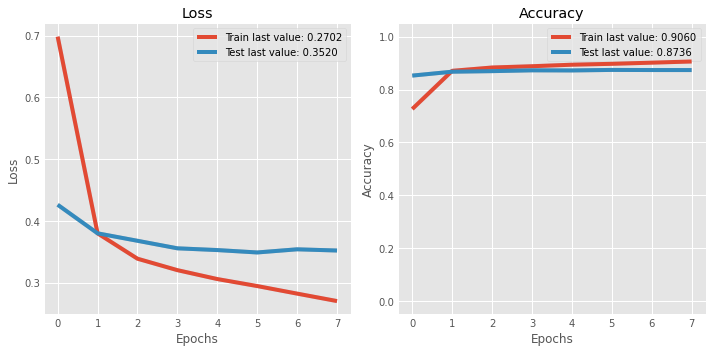

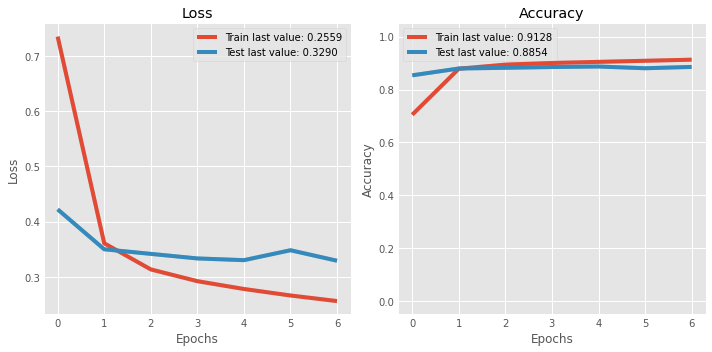

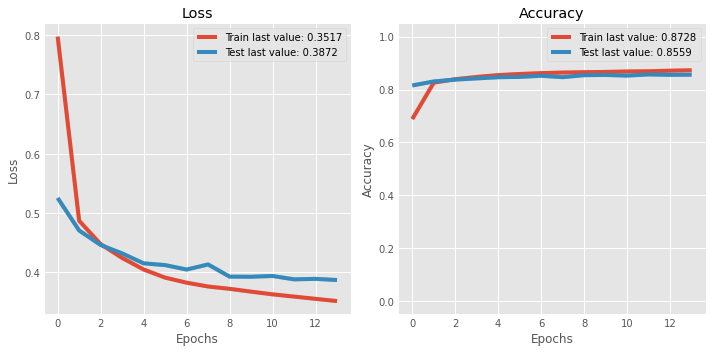

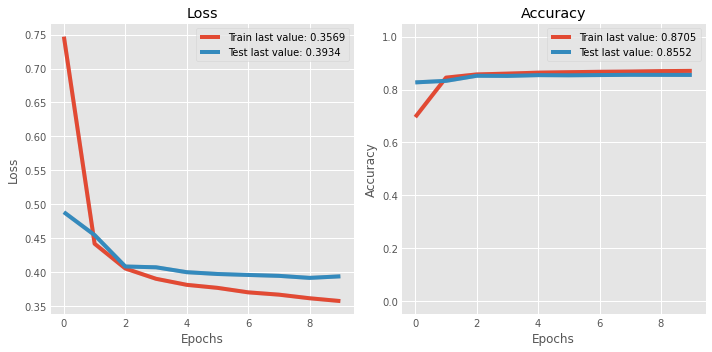

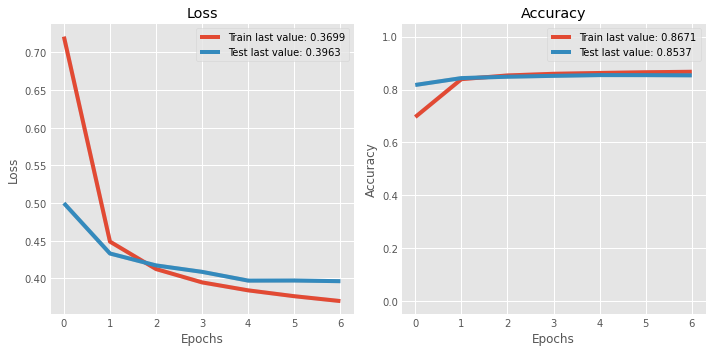

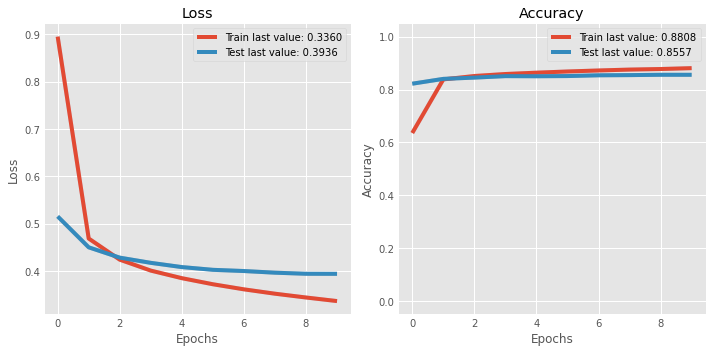

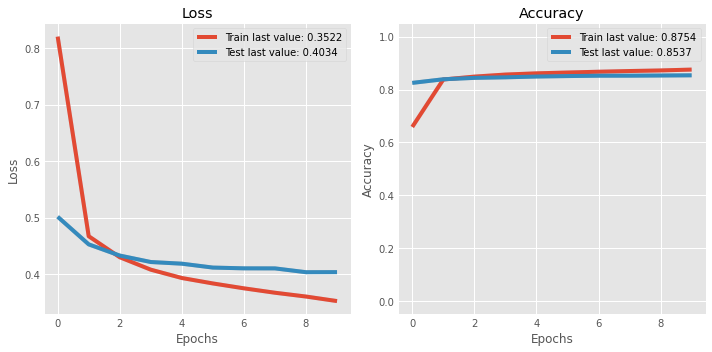

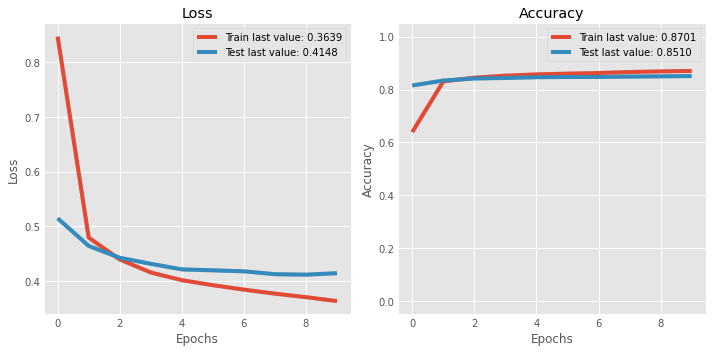

In [187]:
plot_history(model1output.history)
plot_history(model2output.history)
plot_history(model3output.history)
plot_history(model4output.history)
plot_history(model5output.history)
plot_history(model6output.history)
plot_history(model7output.history)
plot_history(model8output.history)
plot_history(model9output.history)